# Машинное обучение, ФКН ВШЭ

# Практическое задание 11. Несбалансированные задачи

## Общая информация
Дата выдачи: 23.04.2024

Мягкий дедлайн: 13.05.2024 23:59 MSK

Жесткий дедлайн: 18.05.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [2]:
"""%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip""";

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [6]:
print(f'Доля положительных:{(df["Class"] == 1).sum() / df.shape[0] * 100} %')

Доля положительных:0.1727485630620034 %


Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [7]:
df['Hour'] =  df['Time'] // 3600 % 24
df['Day'] = df['Time'] // 3600 // 24
print("Данные покрывают",df['Day'].nunique(), 'дня')

Данные покрывают 2 дня


Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

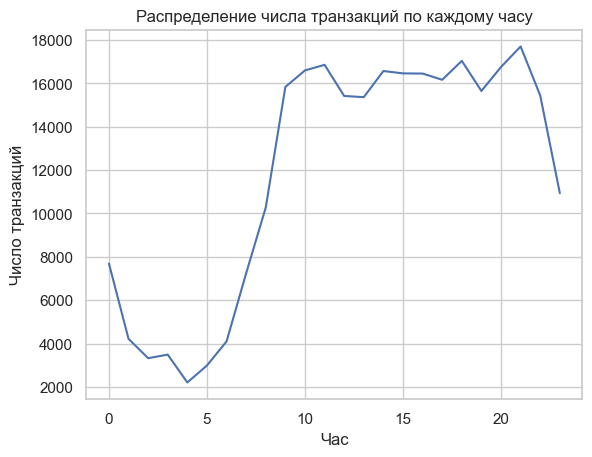

In [8]:
cnt_for_hour = df.groupby("Hour").agg('count')['Class']
for_x = len(cnt_for_hour)
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(0,for_x), cnt_for_hour)
ax.set_xlabel('Час')
ax.set_ylabel('Число транзакций')
ax.set_title('Распределение числа транзакций по каждому часу')
plt.show()

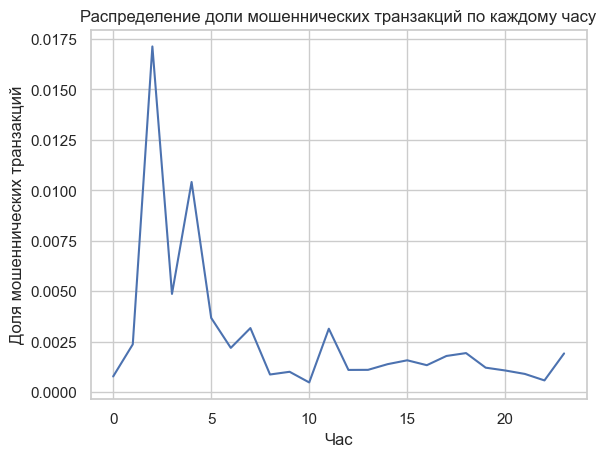

In [9]:
cnt_fraud_for_hour = df.groupby("Hour").agg('mean')['Class']
for_x = len(cnt_fraud_for_hour)
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(0,for_x), cnt_fraud_for_hour)
ax.set_xlabel('Час')
ax.set_ylabel('Доля мошеннических транзакций')
ax.set_title('Распределение доли мошеннических транзакций по каждому часу')
plt.show()

По графикам видно, что больше всего транзакций происходит в вечернее время, а меньше всего под утро в 3 - 4 часа. Мошеннические транзацкии происходят в основном ночью где то в 2-4 часа, в остальное время их количество мало

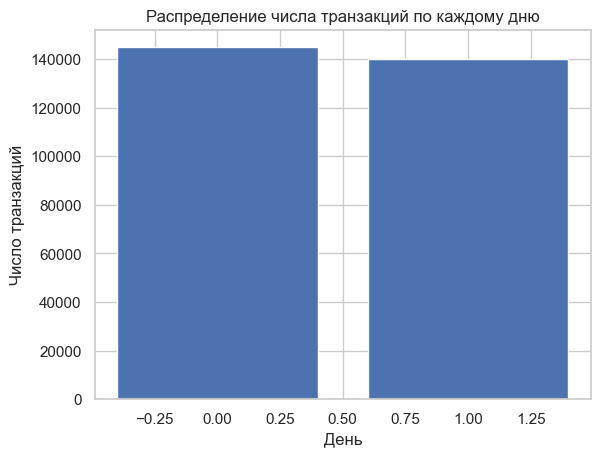

In [10]:
cnt_for_day = df.groupby("Day").agg('count')['Class']
for_x = len(cnt_for_day)
fig, ax = plt.subplots(1, 1)
ax.bar(np.arange(for_x),  cnt_for_day)
ax.set_xlabel('День')
ax.set_ylabel('Число транзакций')
ax.set_title('Распределение числа транзакций по каждому дню')
plt.show()

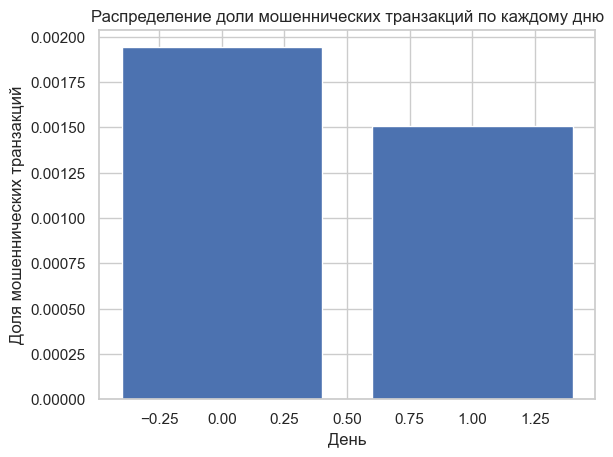

In [11]:
cnt_fraud_for_day = df.groupby("Day").agg('mean')['Class']
for_x = len(cnt_fraud_for_day)
fig, ax = plt.subplots(1, 1)
ax.bar(np.arange(for_x), cnt_fraud_for_day)
ax.set_xlabel('День')
ax.set_ylabel('Доля мошеннических транзакций')
ax.set_title('Распределение доли мошеннических транзакций по каждому дню')
plt.show()

Количество транзакций, как обычных, так и мошеннических, в первый день больше

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

In [12]:
import seaborn as sns

correlation = df.drop(columns = ['Class']).corrwith(df['Class']).abs()
correlation.sort_values(ascending=False)

V17       0.326481
V14       0.302544
V12       0.260593
V10       0.216883
V16       0.196539
V3        0.192961
V7        0.187257
V11       0.154876
V4        0.133447
V18       0.111485
V1        0.101347
V9        0.097733
V5        0.094974
V2        0.091289
V6        0.043643
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
Hour      0.017109
Time      0.012323
V28       0.009536
V24       0.007221
Amount    0.005632
Day       0.005223
V13       0.004570
V26       0.004455
V15       0.004223
V25       0.003308
V23       0.002685
V22       0.000805
dtype: float64

Наибольшую корреляцию имеют V17 - 0.326481, V14 - 0.302544, V12 - 0.260593, V10 - 0.216883, V16 - 0.196539, V3  - 0.192961

Посмотрим на их распределения для разных классов

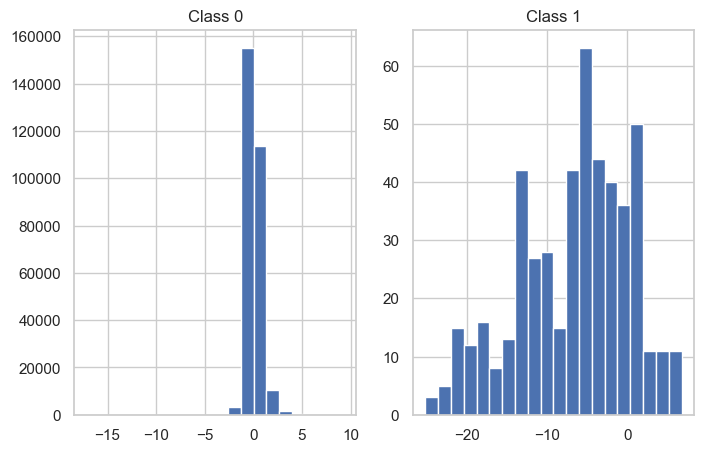

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (8, 5))


ax[0].hist(data=df[df["Class"] == 0], x="V17", bins=20)
ax[0].set_title("Class 0")

ax[1].hist(data=df[df["Class"] == 1], x="V17", bins=20)
ax[1].set_title("Class 1")

plt.show()


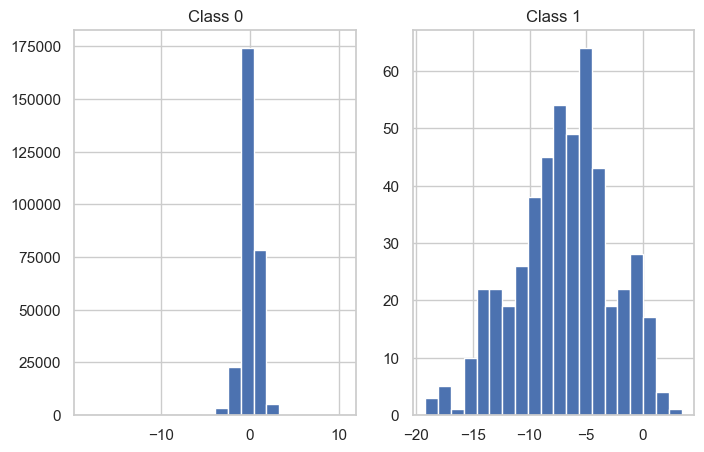

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (8, 5))


ax[0].hist(data=df[df["Class"] == 0], x="V14", bins=20)
ax[0].set_title("Class 0")

ax[1].hist(data=df[df["Class"] == 1], x="V14", bins=20)
ax[1].set_title("Class 1")

plt.show()


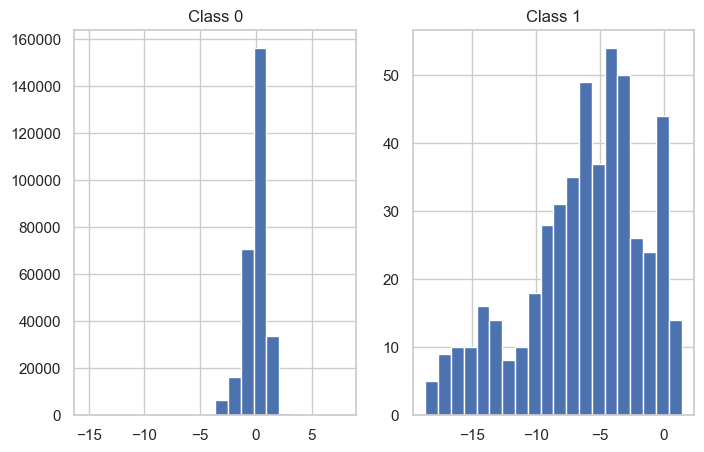

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (8, 5))


ax[0].hist(data=df[df["Class"] == 0], x="V12", bins=20)
ax[0].set_title("Class 0")

ax[1].hist(data=df[df["Class"] == 1], x="V12", bins=20)
ax[1].set_title("Class 1")

plt.show()

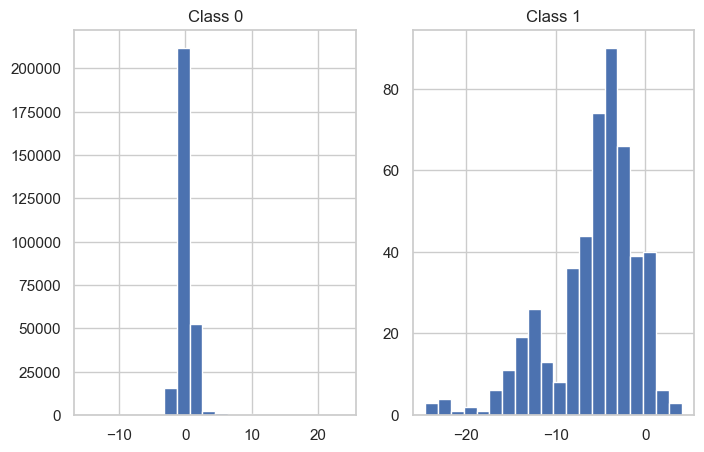

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (8, 5))


ax[0].hist(data=df[df["Class"] == 0], x="V10", bins=20)
ax[0].set_title("Class 0")

ax[1].hist(data=df[df["Class"] == 1], x="V10", bins=20)
ax[1].set_title("Class 1")

plt.show()

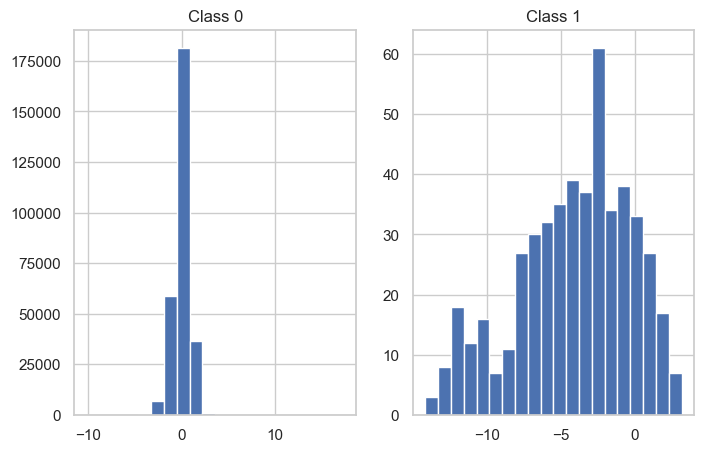

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (8, 5))
ax[0].hist(data=df[df["Class"] == 0], x="V16", bins=20)
ax[0].set_title("Class 0")
ax[1].hist(data=df[df["Class"] == 1], x="V16", bins=20)
ax[1].set_title("Class 1")
plt.show()

У мошеннических транзакций дисперсия признаков гораздо больше, чем у обычных транзакций

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [18]:
size_val_test = int(0.2 * len(df))
df_train = df.iloc[:-size_val_test]
df_val_test = df.iloc[-size_val_test:]
df_val = df_val_test.iloc[:len(df_val_test) // 2]
df_test = df_val_test[len(df_val_test) // 2:]

In [19]:
X_train, y_train = df_train.drop(columns=["Class"]), df_train['Class']
X_val, y_val = df_val.drop(columns=["Class"]), df_val['Class']
X_test, y_test = df_test.drop(columns=["Class"]), df_test['Class']

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [20]:
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

In [21]:
y_pred = np.zeros_like(df['Class'])
print("Коэффициент Каппа Коэна", cohen_kappa_score(df['Class'], y_pred))

Коэффициент Каппа Коэна 0.0


In [22]:
y_pred = np.zeros_like(df['Class'])
print("Коэффициент корреляции Мэтьюза", matthews_corrcoef(df['Class'], y_pred))


Коэффициент корреляции Мэтьюза 0.0


Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [25]:
from catboost import CatBoostClassifier
import optuna
from sklearn.metrics import average_precision_score as auc_pr


In [23]:
def objective(trial):
    num_trees = trial.suggest_int("num_trees", 50, 350, step=20)
    depth = trial.suggest_int("depth", 2, 15)

    clf = CatBoostClassifier(num_trees=num_trees, depth=depth, verbose=False)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    
    return auc_pr(y_val, y_pred)

study = optuna.create_study(direction="maximize")   
study.optimize(objective, n_trials=25)
study.best_params

[I 2024-04-27 13:07:49,599] A new study created in memory with name: no-name-52bd1c69-dc48-429d-ae91-eb3cba9b199b


[I 2024-04-27 13:07:53,987] Trial 0 finished with value: 0.6991236858770513 and parameters: {'num_trees': 290, 'depth': 5}. Best is trial 0 with value: 0.6991236858770513.
[I 2024-04-27 13:08:10,238] Trial 1 finished with value: 0.7179444032223871 and parameters: {'num_trees': 350, 'depth': 10}. Best is trial 1 with value: 0.7179444032223871.
[I 2024-04-27 13:08:36,184] Trial 2 finished with value: 0.6991236858770513 and parameters: {'num_trees': 250, 'depth': 12}. Best is trial 1 with value: 0.7179444032223871.
[I 2024-04-27 13:08:39,447] Trial 3 finished with value: 0.6991236858770513 and parameters: {'num_trees': 110, 'depth': 9}. Best is trial 1 with value: 0.7179444032223871.
[I 2024-04-27 13:08:43,139] Trial 4 finished with value: 0.7212618285890493 and parameters: {'num_trees': 290, 'depth': 2}. Best is trial 4 with value: 0.7212618285890493.
[I 2024-04-27 13:09:11,259] Trial 5 finished with value: 0.7363406296374814 and parameters: {'num_trees': 270, 'depth': 12}. Best is trial

{'num_trees': 270, 'depth': 11}

In [24]:
clf = CatBoostClassifier(num_trees=study.best_params['num_trees'], depth=study.best_params['depth'], verbose=False)
clf.fit(X_train, y_train)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))


Коэффициент Каппа Коэна для валидации 0.8599909242172137
Коэффициент Каппа Коэна для теста 0.7998608632102652
Коэффициент корреляции Мэтьюза для валидации 0.8685459101182709
Коэффициент корреляции Мэтьюза для теста 0.8038960655235946
AUC-PR для валидации 0.7551734418062328
AUC-PR для теста 0.6466753132249428


Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [25]:
coeff = np.sum(y_train == 0) / np.sum(y_train == 1)
clf = CatBoostClassifier(num_trees=study.best_params['num_trees'], depth=study.best_params['depth'],\
                          scale_pos_weight = coeff,
                         verbose=False)
clf.fit(X_train, y_train)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации 0.799670362379255
Коэффициент Каппа Коэна для теста 0.6380003992502469
Коэффициент корреляции Мэтьюза для валидации 0.8051035942874769
Коэффициент корреляции Мэтьюза для теста 0.6393062199436622
AUC-PR для валидации 0.649223900128209
AUC-PR для теста 0.40933668697792147


стало как-то хуже

Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [26]:
def objective(trial):
    num_trees = trial.suggest_int("num_trees", 15, 195, step=20)
    depth = trial.suggest_int("depth", 2, 15)
    scale_pos_weight = trial.suggest_float("scale_pos_weight", 0.1, 1.0)
    
    clf = CatBoostClassifier(num_trees=num_trees, depth=depth, scale_pos_weight = scale_pos_weight, verbose=False)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    
    return auc_pr(y_val, y_pred)

study = optuna.create_study(direction="maximize")   
study.optimize(objective, n_trials=25)
study.best_params

[I 2024-04-27 13:21:24,505] A new study created in memory with name: no-name-b26f214b-76d9-4aea-81e3-d7d117967a6b


[I 2024-04-27 13:21:25,503] Trial 0 finished with value: 0.71750781746873 and parameters: {'num_trees': 55, 'depth': 3, 'scale_pos_weight': 0.10105790133761239}. Best is trial 0 with value: 0.71750781746873.
[I 2024-04-27 13:21:28,241] Trial 1 finished with value: 0.6798421931312274 and parameters: {'num_trees': 115, 'depth': 8, 'scale_pos_weight': 0.2110424109124323}. Best is trial 0 with value: 0.71750781746873.
[I 2024-04-27 13:21:30,331] Trial 2 finished with value: 0.6614842125090958 and parameters: {'num_trees': 135, 'depth': 4, 'scale_pos_weight': 0.7648398722283567}. Best is trial 0 with value: 0.71750781746873.
[I 2024-04-27 13:21:32,084] Trial 3 finished with value: 0.7192345379428006 and parameters: {'num_trees': 115, 'depth': 4, 'scale_pos_weight': 0.5650750909667485}. Best is trial 3 with value: 0.7192345379428006.
[I 2024-04-27 13:23:00,850] Trial 4 finished with value: 0.6986750052999787 and parameters: {'num_trees': 115, 'depth': 15, 'scale_pos_weight': 0.64175995315118

{'num_trees': 195, 'depth': 6, 'scale_pos_weight': 0.43857316610063035}

In [27]:
clf = CatBoostClassifier(num_trees=study.best_params['num_trees'], depth=study.best_params['depth'],\
                        scale_pos_weight = study.best_params['scale_pos_weight'],
                        verbose=False)
clf.fit(X_train, y_train)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации 0.8599909242172137
Коэффициент Каппа Коэна для теста 0.7177586528421791
Коэффициент корреляции Мэтьюза для валидации 0.8685459101182709
Коэффициент корреляции Мэтьюза для теста 0.7237392722838328
AUC-PR для валидации 0.7551734418062328
AUC-PR для теста 0.5243450601367231


**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [129]:
!pip3.11 install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 2.4 MB/s eta 0:00:00a 0:00:01


Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [26]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

Полное выравнивание:

In [29]:
sm = SMOTE(random_state=42, sampling_strategy=1)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
clf = CatBoostClassifier(num_trees=270, depth = 11, verbose=False)
clf.fit(X_train_resampled, y_train_resampled)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации 0.7743359073408023
Коэффициент Каппа Коэна для теста 0.5814301953414787
Коэффициент корреляции Мэтьюза для валидации 0.7751257642459805
Коэффициент корреляции Мэтьюза для теста 0.5934426606164669
AUC-PR для валидации 0.6018475451960261
AUC-PR для теста 0.3528277466501035


Выравнивание на 1/2:

In [30]:
sm = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
clf = CatBoostClassifier(num_trees=270, depth = 11, verbose=False)
clf.fit(X_train_resampled, y_train_resampled)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации 0.8115478485696136
Коэффициент Каппа Коэна для теста 0.6396882805812127
Коэффициент корреляции Мэтьюза для валидации 0.8125476669919791
Коэффициент корреляции Мэтьюза для теста 0.6443525381406625
AUC-PR для валидации 0.6611917885661791
AUC-PR для теста 0.4157950823447119


Выравнивание на 1/10:

In [31]:
sm = SMOTE(random_state=42, sampling_strategy=0.1)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
clf = CatBoostClassifier(num_trees=270, depth = 11, verbose=False)
clf.fit(X_train_resampled, y_train_resampled)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации 0.8196845746316063
Коэффициент Каппа Коэна для теста 0.6797229160721892
Коэффициент корреляции Мэтьюза для валидации 0.821169206162195
Коэффициент корреляции Мэтьюза для теста 0.6846790843276719
AUC-PR для валидации 0.6752507341034466
AUC-PR для теста 0.4693313997894244


Лучшее качество при выравнивании на 1/10

**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

BorderlineSMOTE - https://sci2s.ugr.es/keel/pdf/specific/congreso/han_borderline_smote.pdf

SVM-SMOTE - https://www.researchgate.net/publication/224355120_SVMs_Modeling_for_Highly_Imbalanced_Classification

K-Means-SMOTE - https://arxiv.org/pdf/1711.00837

ADASYN - https://ieeexplore.ieee.org/document/4633969

Теперь попробуйте сравнить качество всех методов на наших данных.

In [28]:
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, ADASYN

In [33]:
border_line = BorderlineSMOTE(sampling_strategy=0.1)
X_train_resampled, y_train_resampled = border_line.fit_resample(X_train, y_train)
clf = CatBoostClassifier(num_trees=270, depth = 11, verbose=False)
clf.fit(X_train_resampled, y_train_resampled)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации 0.8295104636606013
Коэффициент Каппа Коэна для теста 0.7439928940257028
Коэффициент корреляции Мэтьюза для валидации 0.8363760198607977
Коэффициент корреляции Мэтьюза для теста 0.7441944677557768
AUC-PR для валидации 0.7004455537055899
AUC-PR для теста 0.5543232208728505


In [34]:
svm_smote = SVMSMOTE(sampling_strategy=0.1)
X_train_resampled, y_train_resampled = svm_smote.fit_resample(X_train, y_train)
clf = CatBoostClassifier(num_trees=270, depth = 11, verbose=False)
clf.fit(X_train_resampled, y_train_resampled)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации 0.8384510664044773
Коэффициент Каппа Коэна для теста 0.7498260790128315
Коэффициент корреляции Мэтьюза для валидации 0.8467917789048397
Коэффициент корреляции Мэтьюза для теста 0.7536088618289372
AUC-PR для валидации 0.7179444032223871
AUC-PR для теста 0.5684275960688305


In [39]:
kmeans_smote = KMeansSMOTE(sampling_strategy=0.1, cluster_balance_threshold = 0.001)
X_train_resampled, y_train_resampled = kmeans_smote.fit_resample(X_train, y_train)
clf = CatBoostClassifier(num_trees=270, depth = 11, verbose=False)
clf.fit(X_train_resampled, y_train_resampled)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Коэффициент Каппа Коэна для валидации 0.8508216557030261
Коэффициент Каппа Коэна для теста 0.6380003992502469
Коэффициент корреляции Мэтьюза для валидации 0.8578635968833646
Коэффициент корреляции Мэтьюза для теста 0.6393062199436622
AUC-PR для валидации 0.736765710559109
AUC-PR для теста 0.40933668697792147


In [40]:
adasyn = ADASYN(sampling_strategy=0.1)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
clf = CatBoostClassifier(num_trees=270, depth = 11, verbose=False)
clf.fit(X_train_resampled, y_train_resampled)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации 0.8346527146926035
Коэффициент Каппа Коэна для теста 0.6396882805812127
Коэффициент корреляции Мэтьюза для валидации 0.8350082576246659
Коэффициент корреляции Мэтьюза для теста 0.6443525381406625
AUC-PR для валидации 0.6980869726521094
AUC-PR для теста 0.4157950823447119


Лучшее качество из всех модификаций smote показал SVM-SMOTE

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [30]:
from imblearn.under_sampling import RandomUnderSampler

In [42]:
best_strategy = 0
best_value = 0
values = []
for sampling_strategy in tqdm(np.linspace(0.1, 1.0, 70)):
    under_sampling = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)
    X_train_resampled, y_train_resampled = under_sampling.fit_resample(X_train, y_train)
    clf = CatBoostClassifier(num_trees=270, depth = 11, verbose=False)
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred_val = clf.predict(X_val)
    metric = auc_pr(y_val, y_pred_val)
    if metric > best_value:
        best_value = metric
        best_strategy = sampling_strategy
    values.append(metric)
    
print(best_strategy)

  0%|          | 0/70 [00:00<?, ?it/s]

0.11304347826086958


In [43]:
under_sampling = RandomUnderSampler(random_state=42, sampling_strategy = best_value)
X_train_resampled, y_train_resampled = under_sampling.fit_resample(X_train, y_train)
clf = CatBoostClassifier(num_trees=270, depth = 11, verbose=False)
clf.fit(X_train_resampled, y_train_resampled)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации 0.42313523134888575
Коэффициент Каппа Коэна для теста 0.21690954083035474
Коэффициент корреляции Мэтьюза для валидации 0.4999022478978634
Коэффициент корреляции Мэтьюза для теста 0.3120503555794489
AUC-PR для валидации 0.25145705378161143
AUC-PR для теста 0.09820812008405518


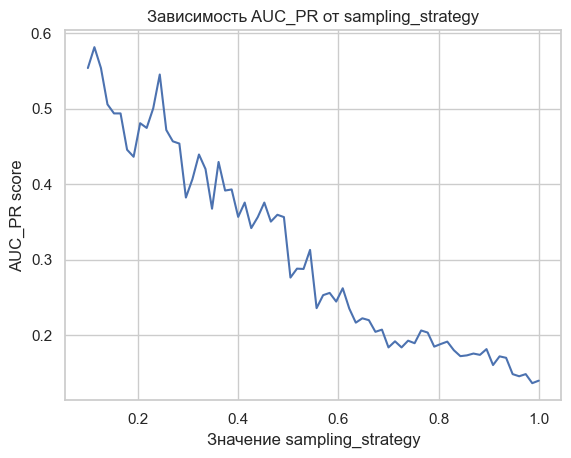

In [44]:
fig, ax = plt.subplots(1, 1)

ax.plot(np.linspace(0.1, 1.0, 70), values)
ax.set_xlabel('Значение sampling_strategy')
ax.set_ylabel('AUC_PR score')
ax.set_title('Зависимость AUC_PR от sampling_strategy')
plt.show()

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [20]:
from imblearn.under_sampling import NearMiss

best_strategy_near_miss = 0
best_value_near_miss = 0
nearmiss_values = []
for sampling_strategy in tqdm(np.linspace(0.1, 1.0, 70)):
    nm = NearMiss(sampling_strategy=sampling_strategy)
    X_train_resampled, y_train_resampled = nm.fit_resample(X_train, y_train)
    clf = CatBoostClassifier(num_trees=270, depth = 11, verbose=False)
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred_val = clf.predict(X_val)
    metric = auc_pr(y_val, y_pred_val)
    if metric > best_value_near_miss:
        best_value_near_miss = metric
        best_strategy_near_miss = sampling_strategy
    nearmiss_values.append(metric)
    
print(best_strategy_near_miss)

  0%|          | 0/70 [00:00<?, ?it/s]

0.8565217391304348


In [21]:
near_miss = NearMiss(sampling_strategy = best_strategy_near_miss)
X_train_resampled, y_train_resampled = near_miss.fit_resample(X_train, y_train)
clf = CatBoostClassifier(num_trees=270, depth = 11, verbose=False)
clf.fit(X_train_resampled, y_train_resampled)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации 0.0630745573110163
Коэффициент Каппа Коэна для теста 0.0239660672548484
Коэффициент корреляции Мэтьюза для валидации 0.1697622622035421
Коэффициент корреляции Мэтьюза для теста 0.09630046790335492
AUC-PR для валидации 0.030812175833528674
AUC-PR для теста 0.010172788233552606


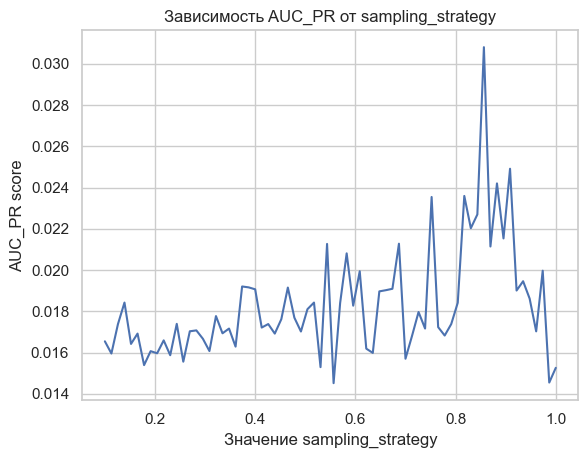

In [22]:
fig, ax = plt.subplots(1, 1)

ax.plot(np.linspace(0.1, 1.0, 70), nearmiss_values)
ax.set_xlabel('Значение sampling_strategy')
ax.set_ylabel('AUC_PR score')
ax.set_title('Зависимость AUC_PR от sampling_strategy')
plt.show()

получилось очень плохо((((

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.


Идея CondensedNearestNeighbour:
1. Найти все примеры маленького класса в исходных данных и положить их в сет C
2. Добавить выборку из целевого класса (класс, подлежащий занижению) в С и все другие выборки этого класса из выборки S
3. Обучим 1NN на C
4. Все данные из выборки S классифицируем с помощью 1NN
5. Если объект был классифицирован неверно, добавляем его в C 
6. Повторяем пункты 3 - 5, пока не пройдем все объекты в S


In [47]:
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=42)
X_train_resampled, y_train_resampled = cnn.fit_resample(X_train, y_train)
clf = CatBoostClassifier(num_trees=270, depth = 11, verbose=False)
clf.fit(X_train_resampled, y_train_resampled)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)
print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))


Коэффициент Каппа Коэна для валидации 0.7193984407020895
Коэффициент Каппа Коэна для теста 0.4149388049120407
Коэффициент корреляции Мэтьюза для валидации 0.7278927912359656
Коэффициент корреляции Мэтьюза для теста 0.4593673572667072
AUC-PR для валидации 0.5309412762348951
AUC-PR для теста 0.21178091469418062


Этот метод сработал гораздо лучше предыдущих

**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [54]:
def H(n):
    return np.log(n) + 0.5772156649

def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    if n <= 1:
        return 0
    return 2 * H(n - 1) - (2 * (n - 1) / n)

def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node
        
        depth: int - path length up to current node
        
        node: Node - current tree node
        
    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    scores = np.zeros(X.shape[0])

    if node.kind == "external":
        return np.full(X.shape[0], depth + c_factor(X.shape[0]))
    
    vals = X @ node.w + node.b
    mask_left_idx =  vals < 0

    left_scores = calc_height(X[mask_left_idx], depth + 1, node.left)
    right_scores = calc_height(X[~mask_left_idx], depth + 1, node.right)

    scores[mask_left_idx] = left_scores
    scores[~mask_left_idx] = right_scores

    return scores


class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
            
        """
        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node 

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
        
    """
    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth
        
        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

        
        
    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        self.depth = max(self.depth, depth)
        
        if depth >= self.max_depth or X.shape[0] == 1:
            self.external_count += 1
            return Node(X, depth, None, None, "external", None, None)
        

        w = np.random.randn(X.shape[1])
        b = np.random.normal()

        vals = X @ w + b
        mask_left_idx = vals < 0
        left = self.grow(X[mask_left_idx], depth + 1)
        right = self.grow(X[~mask_left_idx], depth + 1)
        
        self.internal_count += 1
        return Node(X, depth, left, right, 'internal', w, b)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """

        return calc_height(X, 0, self.root)
        
    
class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        
    """
    
    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
        
    def __repr__(self):
        """For convenience only."""
        
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        self.subsample_size = int(self.subsample_rate * X.shape[0])
        self.is_fit = True
        for _ in range(self.n_trees):
            if self.max_depth is not None:
                max_depth = self.max_depth
            else:
                max_depth = np.ceil(np.log2(self.subsample_size))

            indices = np.random.choice(np.arange(X.shape[0]), size=self.subsample_size)
            X_sampled = np.unique(X[indices], axis=0)
            self.trees.append(RandomizedTree(X_sampled, max_depth))
        
        
        
        return self
    
    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        mean = np.zeros(X.shape[0])
        for tree in self.trees:
            mean += tree.score_samples(X)

        mean /= self.n_trees
        scores = 2 ** (-mean / c_factor(self.subsample_size))

        return scores


    
    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        scores = self.score_samples(X)
        labels = (scores >= np.quantile(scores, 1 - self.contamination))

        return scores, labels


**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [55]:
from sklearn.preprocessing import StandardScaler

In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [58]:
def objective_eif(trial):
    n_trees = trial.suggest_int("n_trees", 10, 100, step=10)
    subsample_rate = trial.suggest_float("subsample_rate", 0.0, 1.0)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    
    eif = ExtendedIsolationForest(n_trees=n_trees, subsample_rate=subsample_rate, max_depth=max_depth)
    eif.fit(X_train_scaled)
    _, y_pred = eif.predict(X_val_scaled)
    return auc_pr(y_val, y_pred)
study_eif = optuna.create_study(direction="maximize")   
study_eif.optimize(objective_eif, n_trials=25)
study_eif.best_params

[I 2024-04-27 13:57:54,627] A new study created in memory with name: no-name-6554d43d-0391-4ac0-b495-e44b30f1f39f
[I 2024-04-27 13:58:15,623] Trial 0 finished with value: 0.02509319129390149 and parameters: {'n_trees': 60, 'subsample_rate': 0.5659640002749721, 'max_depth': 7}. Best is trial 0 with value: 0.02509319129390149.
[I 2024-04-27 13:58:33,084] Trial 1 finished with value: 0.03915132694732379 and parameters: {'n_trees': 40, 'subsample_rate': 0.8531116620758511, 'max_depth': 7}. Best is trial 1 with value: 0.03915132694732379.
[I 2024-04-27 13:59:06,240] Trial 2 finished with value: 0.049175086194392065 and parameters: {'n_trees': 70, 'subsample_rate': 0.8109564550093563, 'max_depth': 10}. Best is trial 2 with value: 0.049175086194392065.
[I 2024-04-27 13:59:48,730] Trial 3 finished with value: 0.06852948136453069 and parameters: {'n_trees': 100, 'subsample_rate': 0.8943740790054463, 'max_depth': 6}. Best is trial 3 with value: 0.06852948136453069.
[I 2024-04-27 14:00:10,582] Tr

{'n_trees': 80, 'subsample_rate': 0.6747193736295047, 'max_depth': 6}

In [59]:
model = ExtendedIsolationForest(n_trees = study_eif.best_params['n_trees'],\
                                subsample_rate = study_eif.best_params['subsample_rate'],\
                                max_depth = study_eif.best_params['max_depth'] ,contamination = 0.01)
model.fit(X_train_scaled)

scores_val, y_pred_val = model.predict(X_val_scaled)
scores_test, y_pred_test = model.predict(X_test_scaled)

print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации 0.15118231185188047
Коэффициент Каппа Коэна для теста 0.08989996365875808
Коэффициент корреляции Мэтьюза для валидации 0.20847340248307758
Коэффициент корреляции Мэтьюза для теста 0.1749695547582677
AUC-PR для валидации 0.04570142662411807
AUC-PR для теста 0.03154085711580181


In [65]:
from sklearn.ensemble import IsolationForest

sklearn_if = IsolationForest(n_estimators=study_eif.best_params['n_trees'], max_samples=study_eif.best_params['subsample_rate'],\
                               contamination=0.01, random_state=42)
sklearn_if.fit(X_train_scaled, y_train)

y_pred_val = (sklearn_if.predict(X_val_scaled) == -1)
y_pred_test = (sklearn_if.predict(X_test_scaled) == -1)

print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации 0.1832947292863547
Коэффициент Каппа Коэна для теста 0.07600735180272056
Коэффициент корреляции Мэтьюза для валидации 0.27077163110997554
Коэффициент корреляции Мэтьюза для теста 0.15985580459498158
AUC-PR для валидации 0.07543190986656342
AUC-PR для теста 0.026484097569878184


Результаты получились очень похожими, но улучшить метрики не получилось

Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [102]:
idx = np.argsort(scores_test[df_test['Class'] == 0])
res = df_test[df_test['Class'] == 0].iloc[idx[-20:]]
res

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour,Day
268364,163174.0,-11.406053,-15.161015,-2.171858,3.100981,8.671023,-5.834923,-4.104816,1.026568,-1.884571,0.035929,-0.908545,-0.059401,-0.366514,2.147868,1.557445,-3.356302,1.924122,0.261161,-0.953686,4.589868,1.567968,-0.779841,0.634224,-0.998243,0.993940,1.273555,-0.087849,-2.150797,563.59,0,21.0,1.0
284249,172273.0,-9.030538,-11.112584,-16.233798,3.592021,-40.427726,23.917837,44.054461,-7.277778,-4.210637,-7.776435,0.214173,-4.499851,0.241005,0.537895,2.901938,2.326099,-0.402142,1.257379,2.008145,2.454553,-0.269048,0.988144,7.040028,0.347693,2.520869,2.342495,3.478175,-2.713136,10199.44,0,23.0,1.0
265400,161870.0,-1.360265,0.591017,0.736333,3.669747,7.476492,-1.754978,-6.245428,-0.857016,-1.218540,1.015745,1.407222,0.459651,-0.926403,-1.658686,-0.108729,0.860097,2.398616,-0.675158,-2.249268,-0.893612,1.138853,-3.196808,-9.897976,-1.456335,-0.962997,-0.120436,0.622279,0.478855,15.16,0,20.0,1.0
264356,161387.0,-7.019052,4.269540,1.563942,-1.571722,-1.028064,1.845536,0.740147,-2.257753,7.404126,12.153414,1.158606,0.422951,0.864540,-6.017857,-1.265434,-3.548272,-1.168983,1.410607,-0.287696,4.089605,-1.105360,-0.146616,-0.474601,-0.564067,1.798423,-0.365865,1.282535,-0.546384,20.00,0,20.0,1.0
280205,169384.0,-14.507512,-18.324137,-0.991375,4.252741,13.028001,-10.580776,-7.822209,1.234624,0.261412,-1.283913,-0.766411,1.412741,1.250059,0.463597,1.044119,0.527365,0.691475,1.125641,-1.269996,5.453226,1.970716,-1.148050,-0.556900,0.153433,0.987871,-0.260791,0.185033,-2.887229,104.25,0,23.0,1.0
264509,161465.0,-10.362593,-9.235096,-2.074512,5.243058,1.004688,1.613001,1.850280,0.448277,-0.712417,0.801080,0.369792,-0.213287,0.058863,0.232016,0.680755,2.253566,-0.995285,-0.224307,-1.840301,-4.106449,-1.032585,1.443410,4.042665,-1.552727,0.755319,0.254726,0.139469,1.791346,752.20,0,20.0,1.0
269532,163677.0,-7.025000,6.482562,-2.986522,-1.239608,-0.629018,2.484863,-4.713088,-15.487784,2.402216,2.842180,-0.581929,1.464823,0.148315,-0.956363,-0.143520,0.039083,1.865077,-0.111400,-0.245879,-2.293179,14.718388,-6.152177,2.458753,0.201598,0.557728,0.371794,1.242422,0.453724,8.99,0,21.0,1.0
282503,170943.0,-11.025028,-12.369532,-1.716078,2.506561,9.021776,-5.882446,-5.559536,-0.288564,0.213490,-0.063428,-0.200818,0.499905,-0.721622,1.847857,2.258174,-0.701520,1.280618,-2.090390,-0.304674,-0.953131,0.667626,-1.215515,-4.854515,-0.418007,-0.303512,1.624997,2.218141,-3.598140,39.99,0,23.0,1.0
258362,158616.0,-9.326717,-11.283392,1.401007,-0.023112,6.529104,-4.894877,-3.291586,0.380540,-0.209074,0.345245,0.444650,-0.291726,0.252064,-0.589125,-0.364519,2.403896,-1.023128,-0.002882,0.265840,-0.822877,-0.038125,1.559860,6.667102,-0.448968,2.609676,0.165168,0.686945,-0.291362,10.00,0,20.0,1.0
274771,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.347360,-3.872425,-12.005487,6.853897,-9.189418,7.126883,-6.795942,8.877742,17.315112,-7.173805,-1.968044,5.501747,-54.497720,-21.620120,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0,22.0,1.0


Наш алгоритм дал большие оценки транзакциям, которые происходили в 20 - 23 часа в первый день. При этом мы знаем, что машеннические транзакции в это время не очень активны

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [69]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [30]:
local_out = LocalOutlierFactor(novelty=True)
local_out.fit(X_train_scaled, y_train)

y_pred_val = local_out.predict(X_val_scaled) 
y_pred_test = local_out.predict(X_test_scaled)

print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации 8.77832153522995e-06
Коэффициент Каппа Коэна для теста 5.107238207513465e-05
Коэффициент корреляции Мэтьюза для валидации 0.00028047603006572524
Коэффициент корреляции Мэтьюза для теста 0.001855928992302174
AUC-PR для валидации 0.0018697684721882227
AUC-PR для теста 0.0008294108034766902


In [31]:
y_pred_test = OneClassSVM().fit_predict(X_test_scaled)
y_pred_val = OneClassSVM().fit_predict(X_val_scaled)


print("Коэффициент Каппа Коэна для валидации", cohen_kappa_score(y_val, y_pred_val))
print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test, y_pred_test))
print("Коэффициент корреляции Мэтьюза для валидации", matthews_corrcoef(y_val, y_pred_val))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test, y_pred_test))
print("AUC-PR для валидации", auc_pr(y_val, y_pred_val))
print("AUC-PR для теста", auc_pr(y_test, y_pred_test))

Коэффициент Каппа Коэна для валидации -0.0008961335996373609
Коэффициент Каппа Коэна для теста -0.00035120621446727007
Коэффициент корреляции Мэтьюза для валидации -0.020773278165214466
Коэффициент корреляции Мэтьюза для теста -0.012636550025175858
AUC-PR для валидации 0.00182716778438315
AUC-PR для теста 0.0007405259178989388


IF и EIF дали лучше результаты, но это в том числе связано с тем, что для LocalOutlierFactor и OneClassSVM не было перебора гиперпараметров

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [104]:
cur = OneClassSVM(nu=0.01).fit_predict(X_train_scaled)
X_train['one_class'] = cur

In [110]:
X_train['lof'] = LocalOutlierFactor().fit_predict(X_train_scaled)

In [113]:
sklearn_if = IsolationForest(n_estimators=study_eif.best_params['n_trees'], max_samples=study_eif.best_params['subsample_rate'],\
                               contamination=0.01, random_state=42)
sklearn_if.fit(X_train_scaled, y_train)
y_pred = (sklearn_if.predict(X_train_scaled) == -1)
X_train['if'] = y_pred

In [123]:
scaler = StandardScaler()
X_train_scaled_new = scaler.fit_transform(X_train[:int(np.ceil(0.9 * X_train.shape[0]))])
X_test_scaled_new = scaler.transform(X_train[int(np.ceil(0.9 * X_train.shape[0])):])

In [124]:
y_train_new = y_train[:int(np.ceil(0.9 * X_train.shape[0]))]
y_test_new = y_train[int(np.ceil(0.9 * X_train.shape[0])):]

In [125]:
sklearn_if = IsolationForest(n_estimators=study_eif.best_params['n_trees'], max_samples=study_eif.best_params['subsample_rate'],\
                               contamination=0.01, random_state=42)
sklearn_if.fit(X_train_scaled_new, y_train_new)

y_pred_test = (sklearn_if.predict(X_test_scaled_new) == -1)

print("Коэффициент Каппа Коэна для теста", cohen_kappa_score(y_test_new, y_pred_test))
print("Коэффициент корреляции Мэтьюза для теста", matthews_corrcoef(y_test_new, y_pred_test))
print("AUC-PR для теста", auc_pr(y_test_new, y_pred_test))

Коэффициент Каппа Коэна для теста 0.08070036411829407
Коэффициент корреляции Мэтьюза для теста 0.17350713568181214
AUC-PR для теста 0.031342456513765014


Метрики немного выросли, но совсем незначительно

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `your text here`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [78]:
import random

rng = random.SystemRandom(0)
rng.uniform(-1.0, 1.0)

0.33003105680983524